# GRU Model with Decay Mechanism

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
train_x = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/train_x.csv')
train_y = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/train_y.csv')
test_x = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/test_x.csv')

In [3]:
# Display the first few rows
print(train_x.head())
print(train_x.shape)

   Hour  ID    Age  Gender  Unit1  Unit2     HR   O2Sat   Temp     SBP  ...  \
0     1   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
1     2   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
2     3   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
3     4   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
4     5   2  66.67     1.0    0.0    1.0  84.42   99.58  35.61  114.60  ...   

   Phosphate  Potassium  Bilirubin_total  TroponinI    Hct   Hgb  PTT   WBC  \
0        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
1        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
2        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
3        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
4        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   

   Fibrinogen  Platelets  
0         NaN        Na

In [4]:
print(train_y.head())
print(train_y.shape)

   ID  Outcome
0   2        0
1   3        0
2   5        1
3   6        0
4  13        0
(12115, 2)


In [5]:
max_hours = train_x.groupby('ID')['Hour'].count().max()
print(f'Maximum number of hours: {max_hours}')

Maximum number of hours: 336


In [6]:
# Get unique person IDs
person_ids = train_x['ID'].unique()

# Initialize tensors for features, masks, and time intervals
num_persons = len(person_ids)
num_features = train_x.shape[1] - 2  # excluding 'ID' and 'Hour' columns

In [7]:
person_ids

array([    2,     3,     5, ..., 21630, 21632, 21633])

In [8]:
#Initialize tensors
X_tensor = np.zeros((num_persons, max_hours, num_features))
M_tensor = np.zeros((num_persons, max_hours, num_features))
Delta_tensor = np.zeros((num_persons, max_hours, num_features))

In [9]:
for i, person_id in enumerate(person_ids):
    person_data = train_x[train_x['ID'] == person_id].sort_values('Hour')
    hours = person_data['Hour'].values
    features = person_data.drop(columns=['ID', 'Hour']).values
    
    # Fill X_tensor
    X_tensor[i, :len(hours), :] = features
    
    # Fill M_tensor (masking)
    M_tensor[i, :len(hours), :] = ~np.isnan(features)
    
    # Fill Delta_tensor (time intervals)
    for t in range(1, len(hours)):
        for f in range(num_features):
            Delta_tensor[i, t, f] = (hours[t] - hours[t-1]) + Delta_tensor[i, t-1, f] * (1 - M_tensor[i, t-1, f])

In [10]:
X_tensor

array([[[ 66.67,   1.  ,   0.  , ...,   8.15,    nan,    nan],
        [ 66.67,   1.  ,   0.  , ...,   8.15,    nan,    nan],
        [ 66.67,   1.  ,   0.  , ...,   8.15,    nan,    nan],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[ 79.74,   0.  ,   0.  , ...,   6.82, 267.01, 281.18],
        [ 79.74,   0.  ,   0.  , ...,   6.82, 267.01, 281.18],
        [ 79.74,   0.  ,   0.  , ...,   6.82, 267.01, 281.18],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[ 60.74,   1.  ,    nan, ...,  12.45,    nan,  84.77],
        [ 60.74,   1.  ,    nan, ...,  12.45,    nan,  84.77],
        [ 60.74,   1.  ,    nan, ...,  12.45,    nan,  84.77],
        ...,
        [  0

In [11]:
M_tensor

array([[[1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 0., ..., 1., 0., 1.],
        [1., 1., 0., ..., 1., 0., 1.],
        [1., 1., 0., ..., 1., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[1., 1., 1., ..., 1., 0., 1.],
        [1., 1., 1., ..., 1., 0., 1.],
        [1., 1., 1., ..., 1., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [12]:
Delta_tensor

array([[[0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 2., 2.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 2., ..., 1., 2., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 2., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [13]:
# Replace NaNs with zeros in X_tensor (not necessary in M_tensor and Delta_tensor)
X_tensor = np.nan_to_num(X_tensor)

print(X_tensor.shape, M_tensor.shape, Delta_tensor.shape)

(12115, 336, 38) (12115, 336, 38) (12115, 336, 38)


In [14]:
# Ensure train_y is aligned with X_tensor
labels = np.zeros(len(person_ids))

for i, person_id in enumerate(person_ids):
    if person_id in train_y['ID'].values:
        labels[i] = train_y[train_y['ID'] == person_id]['Outcome'].values[0]

labels = labels.reshape(-1, 1)
print(labels.shape)

(12115, 1)


In [15]:
# Split the data into training and test sets
X_train, X_test, M_train, M_test, Delta_train, Delta_test, y_train, y_test = train_test_split(
    X_tensor, M_tensor, Delta_tensor, labels, test_size=0.2, random_state=10
)

In [16]:
class GRUD(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUD, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # GRU weights
        self.reset_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.update_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.new_gate = nn.Linear(input_size + hidden_size, hidden_size)
        
        # Decay parameters
        self.gamma_x = nn.Linear(input_size, input_size)
        self.gamma_h = nn.Linear(input_size, hidden_size)
        
        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, m, d, h):
        # Decay mechanism for inputs
        gamma_x = torch.exp(-torch.max(self.gamma_x(d), torch.zeros_like(d)))
        x_hat = m * x + (1 - m) * gamma_x * x
        
        # Decay mechanism for hidden state
        d_h = d.mean(dim=1, keepdim=True)
        gamma_h = torch.exp(-torch.max(self.gamma_h(d), torch.zeros_like(d_h)))
        h_hat = gamma_h * h
        
        # Concatenate inputs
        combined = torch.cat((x_hat, h_hat), dim=1)
        
        # GRU gates
        reset = torch.sigmoid(self.reset_gate(combined))
        update = torch.sigmoid(self.update_gate(combined))
        new = torch.tanh(self.new_gate(torch.cat((x_hat, reset * h_hat), dim=1)))
        
        # Compute new hidden state
        h_new = (1 - update) * h + update * new
        
        # Output layer
        out = self.fc(h_new)
        return out, h_new

In [17]:
# Hyperparameters
input_size = 38  # The number of input features
hidden_size = 64  # Size of the hidden state
output_size = 1  # Size of the output
num_epochs = 50
batch_size = 16
learning_rate = 0.001

In [18]:
# Initialize model, criterion, and optimizer
model = GRUD(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
model.eval()

GRUD(
  (reset_gate): Linear(in_features=102, out_features=64, bias=True)
  (update_gate): Linear(in_features=102, out_features=64, bias=True)
  (new_gate): Linear(in_features=102, out_features=64, bias=True)
  (gamma_x): Linear(in_features=38, out_features=38, bias=True)
  (gamma_h): Linear(in_features=38, out_features=64, bias=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [20]:
# Create DataLoader
train_dataset = TensorDataset(torch.tensor(X_tensor, dtype=torch.float32), 
                              torch.tensor(M_tensor, dtype=torch.float32), 
                              torch.tensor(Delta_tensor, dtype=torch.float32), 
                              torch.tensor(labels, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [21]:
for batch in train_loader:
    X_batch, M_batch, Delta_batch, labels_batch = batch
    print(f'X_batch shape: {X_batch.shape}')
    print(f'M_batch shape: {M_batch.shape}')
    print(f'Delta_batch shape: {Delta_batch.shape}')
    print(f'Labels_batch shape: {labels_batch.shape}')
    break

X_batch shape: torch.Size([16, 336, 38])
M_batch shape: torch.Size([16, 336, 38])
Delta_batch shape: torch.Size([16, 336, 38])
Labels_batch shape: torch.Size([16, 1])


In [22]:
# Training loop
train_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, M_batch, Delta_batch, y_batch in train_loader:
        # Initialize hidden state
        h = torch.zeros((X_batch.size(0), hidden_size))
        
        optimizer.zero_grad()
        
        # Forward pass
        for t in range(X_batch.size(1)):
            x_t = X_batch[:, t, :]
            m_t = M_batch[:, t, :]
            d_t = Delta_batch[:, t, :]
            
            output, h = model(x_t, m_t, d_t, h)
        
        # Compute loss
        loss = criterion(output, y_batch)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

KeyboardInterrupt: 

In [41]:
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                             torch.tensor(M_test, dtype=torch.float32), 
                             torch.tensor(Delta_test, dtype=torch.float32), 
                             torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

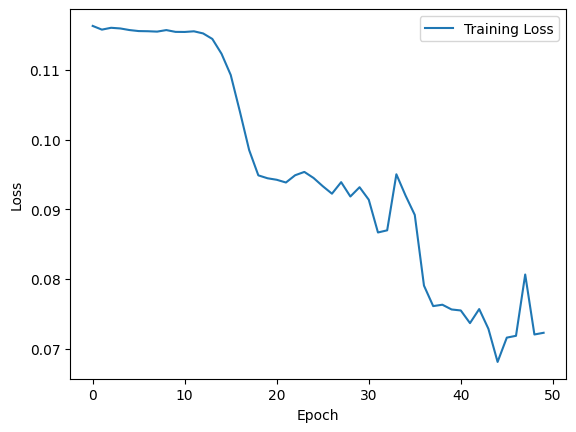

In [42]:
# Plot the training loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
# Evaluation on the test set
total_correct = 0
total_samples = 0
with torch.no_grad():
    for X_batch, M_batch, Delta_batch, y_batch in test_loader:
        # Initialize hidden state
        h = torch.zeros((X_batch.size(0), hidden_size))
        
        # Forward pass
        for t in range(X_batch.size(1)):
            x_t = X_batch[:, t, :]
            m_t = M_batch[:, t, :]
            d_t = Delta_batch[:, t, :]
            
            output, h = model(x_t, m_t, d_t, h)
        
        # Convert output to binary prediction
        predictions = (output >= 0.5).float()
        total_correct += (predictions == y_batch).sum().item()
        total_samples += y_batch.size(0)

accuracy = total_correct / total_samples
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9092
